In [ ]:
from examples.train_model import main
import torch 
import importlib
from examples.benchmark import local_get_args
from utils.rng import set_seed
from examples.train_and_visu_non_recurrent import evaluate_config
import matplotlib.pyplot as plt
import numpy as np
import os 
import geopandas as gpd
from plotting.plotting import plot_heatmap

## Load trained model and trainer from save: 

In [121]:
from examples.load_best_config import load_trainer_ds_from_saved_trial
from argparse import Namespace
import pickle


working_dir = os.path.expanduser('~/prediction-validation/save/K_fold_validation/training_wo_HP_tuning/optim')
subfolder = 'best_models'


### --------- Subway-In Prection with STGCN: 
target_data = 'subway_in'
model_name = 'STGCN'
tag = 'iris'
## ---- Agg 100 Zones ----
# trial_id = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_Agg100_attn_dim48_ff64_h2_l2_unormalized_loss_concatenated_L_out4'      # MAE = 21.60, MSE = 1500.53 -> Gain Matin 
# trial_id = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_Agg100_attn_dim64_ff64_h4_l2_unormalized_loss_concatenated_L_out4'      # MAE = 21.58, MSE = 1505.71 -> Gain Matin 
# trial_id = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_Agg100_attn_dim128_ff128_h4_l16_unormalized_loss_concatenated_L_out32'  # MAE = 22.13, MSE = 1576.71 -> Gain Matin tot ,horizon 1 
# trial_id = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_Agg100_attn_dim128_ff128_h4_l4_unormalized_loss_concatenated_L_out4'    # MAE = 21.75, MSE = 1509.29 -> Gain Matin 8h horizon 1, et fort gain horizon 3 et 4
# trial_id = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_Agg100_attn_dim128_ff128_h4_l16_unormalized_loss_concatenated_L_out16'  # MAE = 21.89, MSE = 1524.35 -> Gain Matin

## ---- Agg 30 Zones ----
# trial_id = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_Agg30_attn_dim128_ff128_h4_l16_unormalized_loss_concatenated_L_out4'    # MAE = 21.87, MSE = 1499.16 --> MAUVAIS: Gain Matin horizon 4 seulement
# trial_id = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_Agg30_attn_dim64_ff64_h4_l2_unormalized_loss_concatenated_L_out4'       # MAE = 21.60, MSE = 1499.48 --> BIZARRE : Gain 9-10h horizon 3 et très fort h4
trial_id = 'subway_in_calendar_emb64_out64_Google_Maps_Web_Weather_IRIS_Agg30_attn_dim128_ff128_h4_l8_unormalized_loss_concatenated_L_out4'     # MAE = 21.87, MSE = 1524.24 --> BIZARRE : Gain 9h fort  horizon 3 et 4
model_id = f"_{trial_id}_f5"     # One trial_id can be associated to several folds 


model_args = pickle.load(open(f"{working_dir}/{target_data}_{model_name}/{subfolder}/model_args.pkl",'rb'))
model_save_path = f"{working_dir}/{target_data}_{model_name}/{subfolder}/{model_id}.pkl"

args = model_args['model'][model_id]['args']
args = Namespace(**args)

trainer, ds, args_init = load_trainer_ds_from_saved_trial(args,model_save_path,
                                                          modification = {'shuffle':False,
                                                                                               'data_augmentation':False })


----------------------------------------
Loading the Complete Dataset for K-fold splitting
Coverage Period: 7392 elts between 2019-03-16 00:00:00 and 2019-05-31 23:45:00
Invalid dates within this fold: 776

>>>Tackle Target dataset: subway_in
   Load data from: //home/rrochas/../../data/rrochas/prediction_validation/subway_in/subway_in.csv
   Init Dataset: 'torch.Size([7392, 40]). 0 Nan values
   TRAIN contextual_ds: torch.Size([2819, 40, 7])
   VALID contextual_ds: torch.Size([940, 40, 7])
   TEST contextual_ds: torch.Size([939, 40, 7])

>>>Loading calendar embedding inputs ...
    dict_keys(['dayofweek_OHE', 'hour_OHE'])
   args_embedding.variable_selection_model_name:  MLP

>>>Tackle Contextual dataset:  netmob_POIs
    ATTENTION: Dimension reduction by clustering is applied on the entire dataset. This should be done only on the training set.
    Netmob_T.size(): torch.Size([7392, 58]). Dimensionality reduced by 3.3%


Restraining all datasets to train common dates: 2819 dates
Restr

## Load DS and Trainer from scratch: 

In [ ]:
station = ['PAR']
target_data = 'subway_in' # 'subway_in' # 
model_name = 'STAEformer' # 'STGCN', 'ASTGCN' # 'STGformer' #'STAEformer' # 'DSTRformer'

config_file = importlib.import_module(f"constants.config_by_datasets.{target_data}.{model_name}")
importlib.reload(config_file)
modification = config_file.config
SEED = config_file.SEED

modification.update({'num_workers' : 4, # 0,1,2, 4, 6, 8 ... A l'IDRIS ils bossent avec 6 num workers par A100 80GB
                    'persistent_workers' : True ,# False 
                    'pin_memory' : True ,# False 
                    'prefetch_factor' : 4, # None, 2,3,4,5 ... 
                    'drop_last' : False,  # True
                    'mixed_precision' : False, # True # False
                    'torch_compile' : False, # 'compile' # 'jit_script' #'trace' # False
                    'device': torch.device('cuda:0'),
                    'epochs': 2
                })

args_init = local_get_args(model_name,
                args_init = None,
                dataset_names=modification['dataset_names'],
                dataset_for_coverage=modification['dataset_for_coverage'],
                modification = modification)

set_seed(SEED)


# Run the script
fold_to_evaluate=[args_init.K_fold-1]

if False:
    trial_id = f"{args_init.model_name}_{'_'.join(args_init.dataset_names)}_fold_{str(fold_to_evaluate[0])}_epochs_{args_init.epochs}"
    save_folder = f"K_fold_validation/training_wo_HP_tuning/{trial_id}"
    print(f"Save folder: {save_folder}")
    trainer,ds,model,args = main(fold_to_evaluate,save_folder,modification)

training_mode_to_visualise = ['test'] # ['test','valid','train']

tag = 'iris'
app = 'Deezer'
L_osmid = [osmid[3:12] for osmid in os.listdir(f"{netmob_folder}/netmob_POI_Lyon/{tag}/{app}") if 'DL' in osmid]
(trainer,ds,ds_no_shuffle,args) = evaluate_config(args_init=args_init,
                                                  modification=modification,
                                                  fold_to_evaluate= fold_to_evaluate,
                                                  station=station,
                                                   training_mode_to_visualise=training_mode_to_visualise,
                                                   type_POIs = [tag,tag,tag],#['iris','iris','iris','iris','iris'],  #'stadium'
                                                   spatial_units = ['Charmettes', 'Charles Hernu', 'Les Brotteaux'], #['Charmettes', 'Charles Hernu', 'Les Brotteaux', 'Bellecombe-Thiers', 'Tonkin Sud'],  #'Matmut Stadium Gerland',
                                                   apps = [app], #['Instagram','Google_Maps','Twitter'],
                                                   POI_or_stations = ['POI','POI','POI'],#['POI','POI','POI','POI','POI',], #'POI',
                                                   transfer_modes =['DL'], #['DL','UL'],
                                                   expanded= '',
                                                   individual_poi = False,
                                                   sum_ts_pois = True
                                                   )

## Analyse attn weights

In [ ]:
X = torch.cat([x for x,y,x_c  in trainer.dataloader['test']]).to(args_init.device)
Y = torch.cat([y for x,y,x_c  in trainer.dataloader['test']]).to(args_init.device)
Xc0 = torch.cat([x_c[0] for x,y,x_c  in trainer.dataloader['test']]).to(args_init.device)
Xc1 = torch.cat([x_c[1] for x,y,x_c  in trainer.dataloader['test']]).to(args_init.device)
Xc2 = torch.cat([x_c[2] for x,y,x_c  in trainer.dataloader['test']]).to(args_init.device)
model = trainer.model
model.eval()
with torch.no_grad():
    pred = model(X,[Xc0,Xc1,Xc2])
    
test_NetMob_attn_weights = trainer.model.spatial_attn_poi.netmob_POIs.attn_weight

if model_name == 'STAEformer':
    test_spatial_attn_weight = trainer.model.core_model.attn_layers_s[-1].attn.attn_score

# Heat map visualisation of attn weight: 
## Average Spatial Attention Weights: 

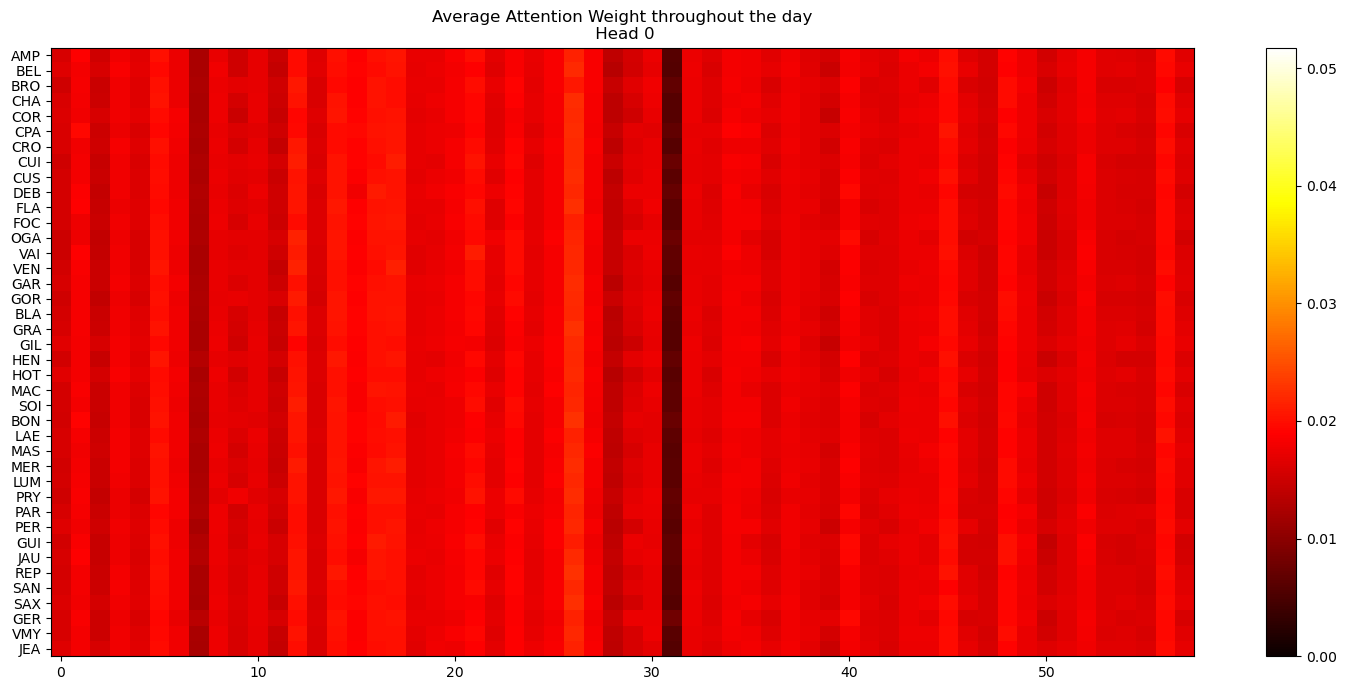

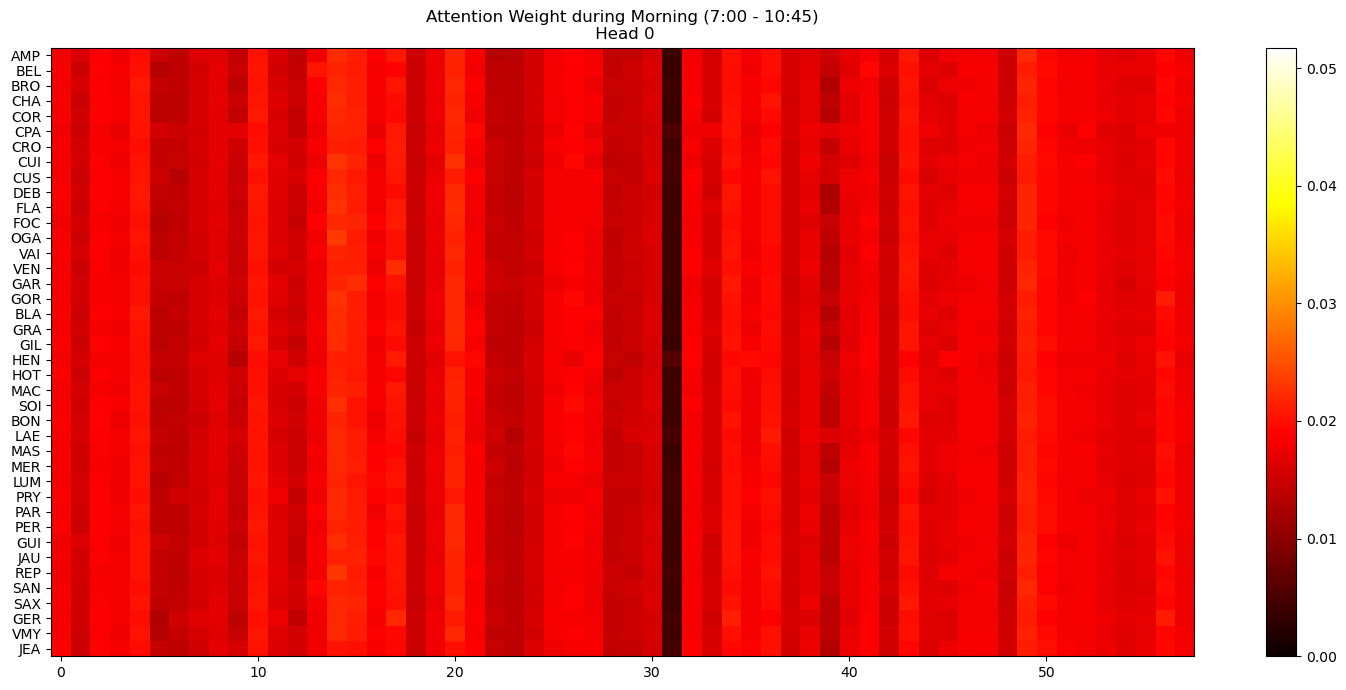

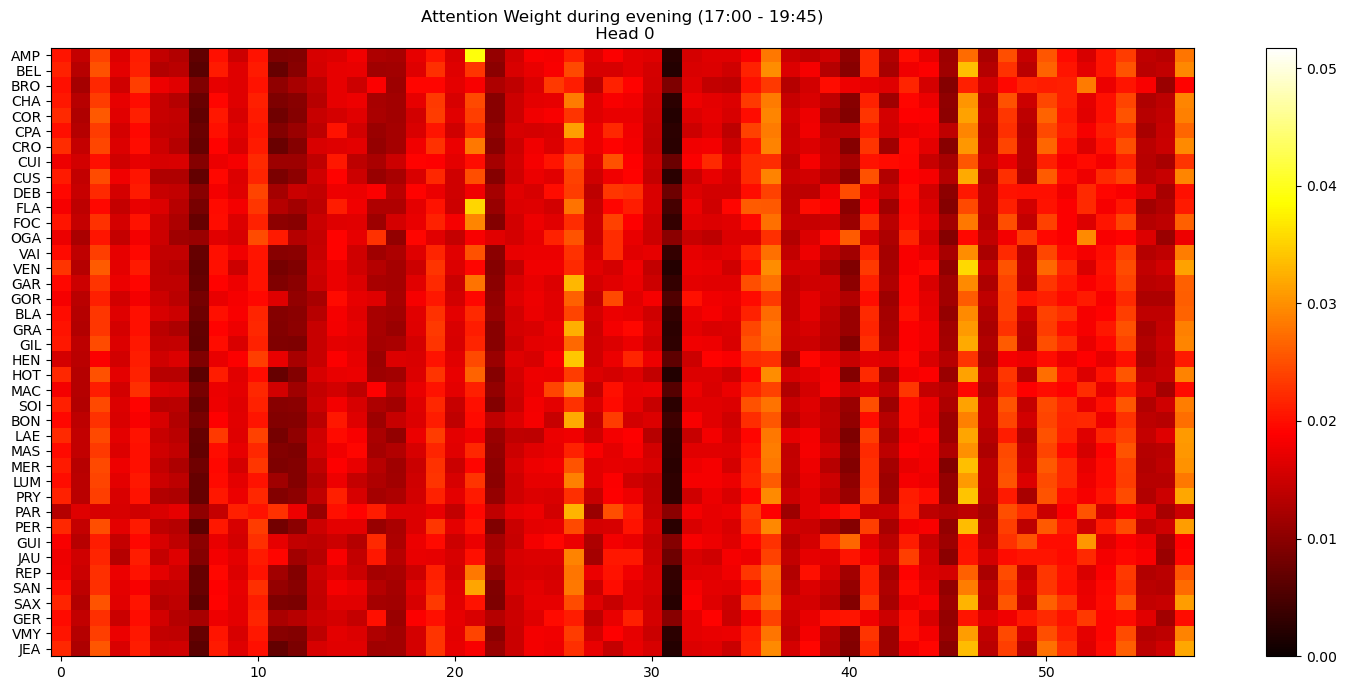

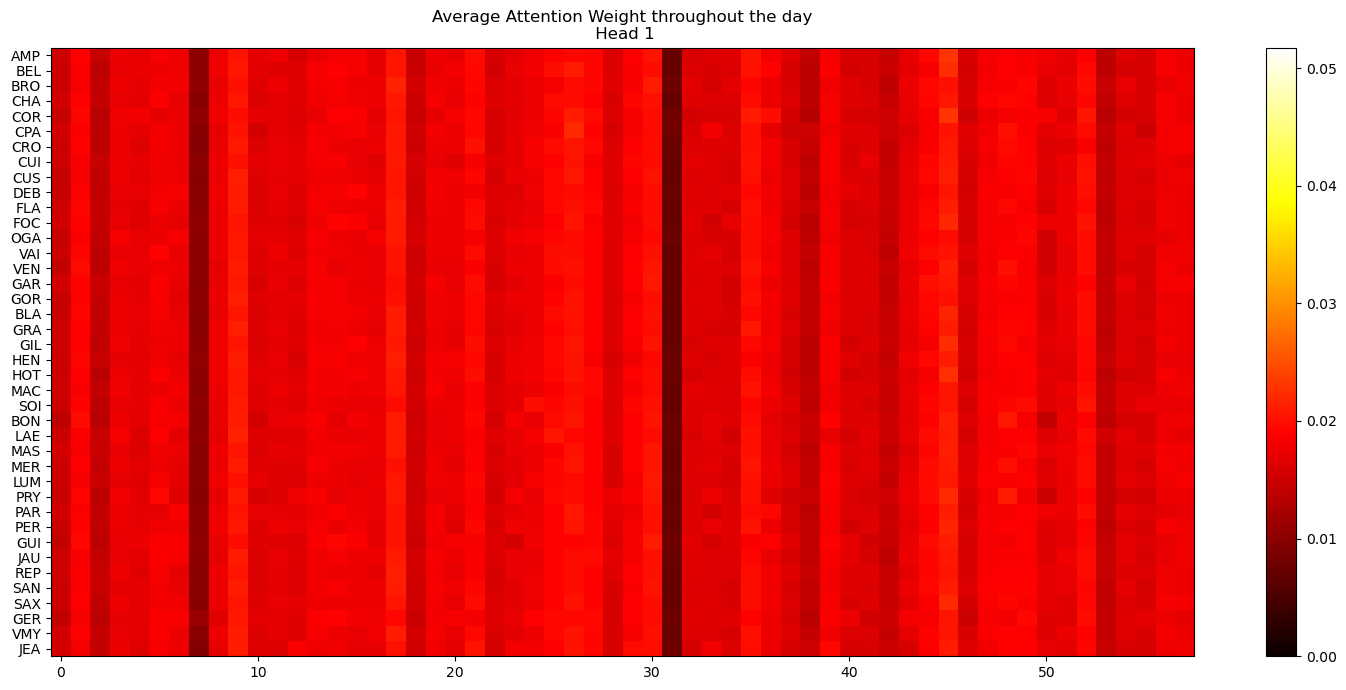

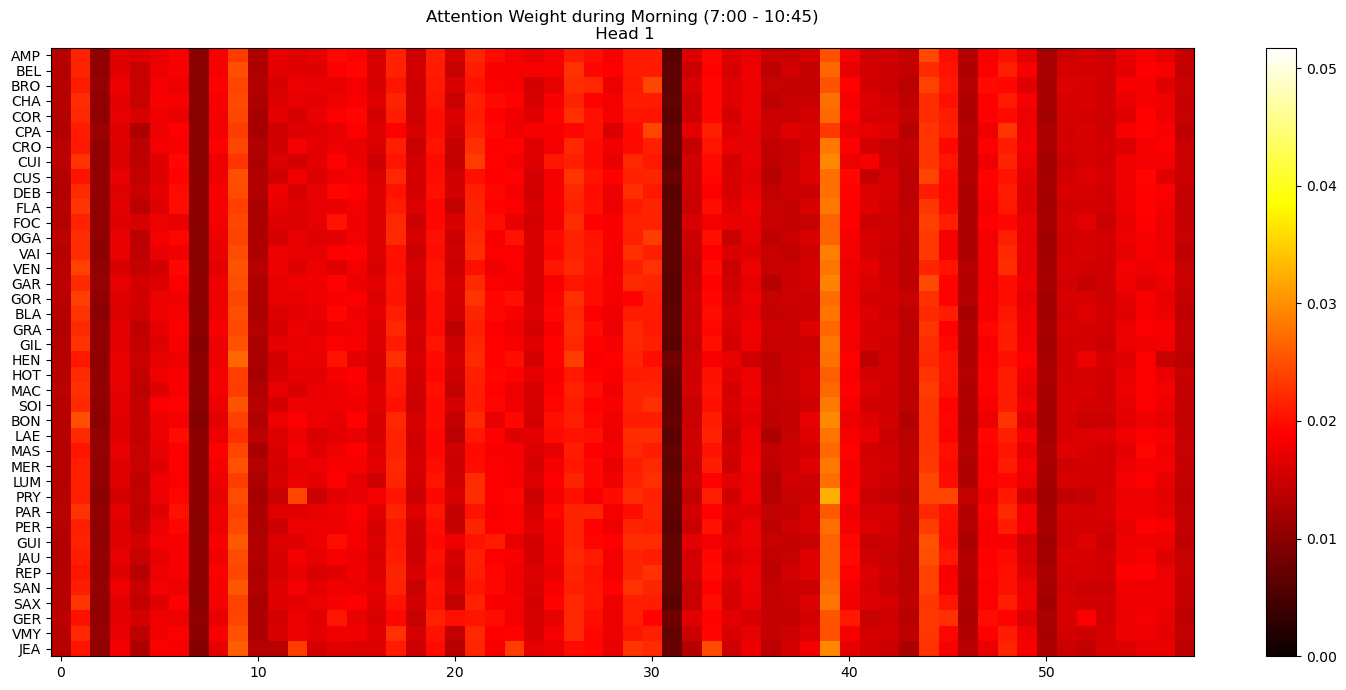

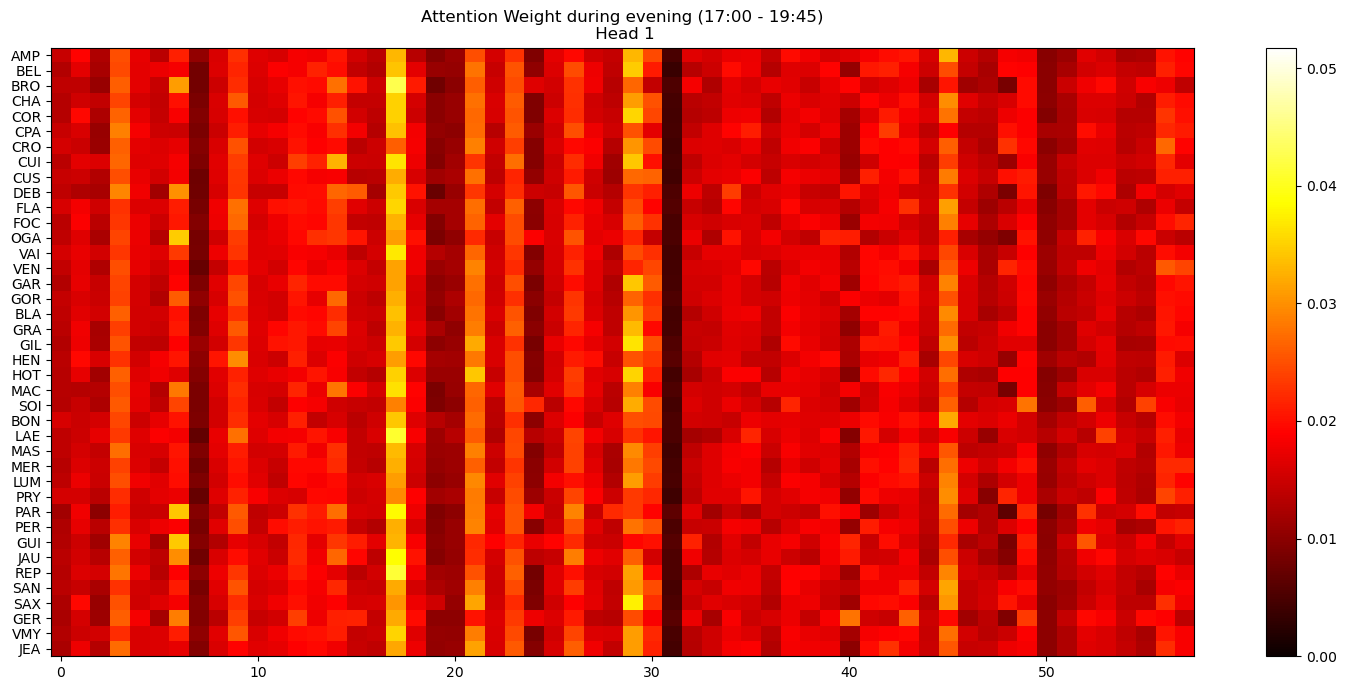

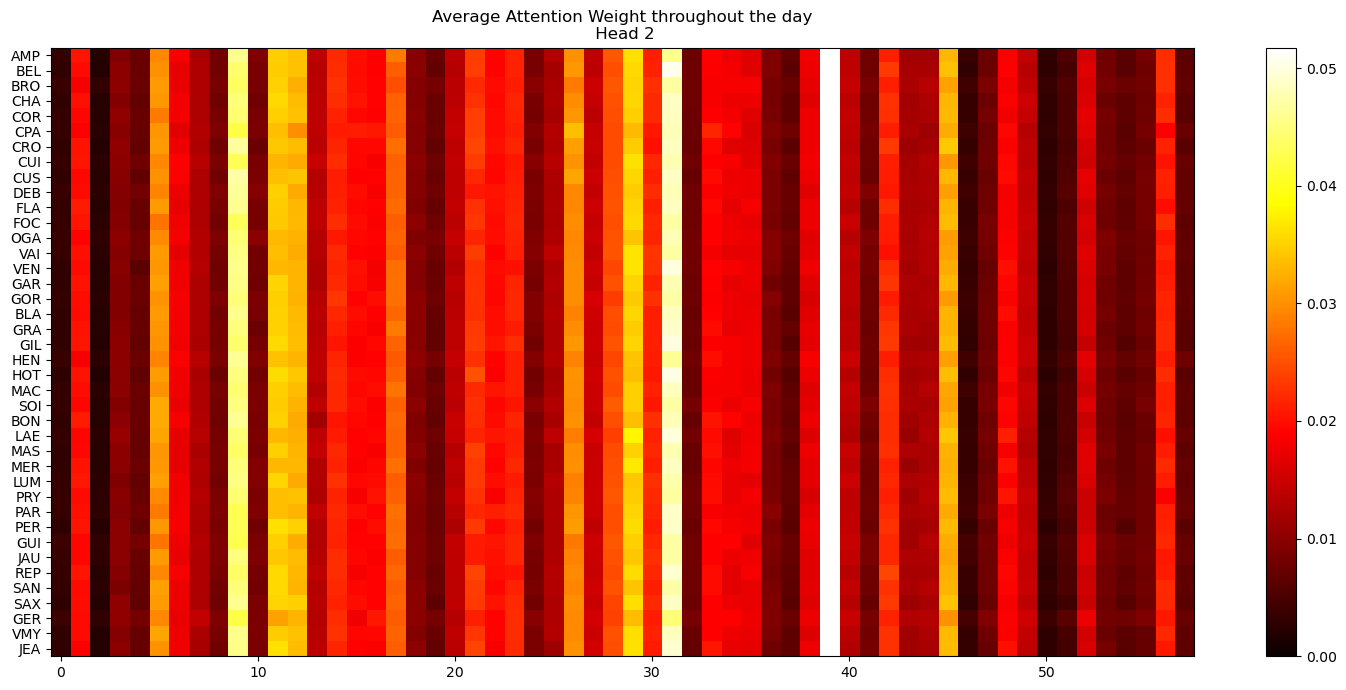

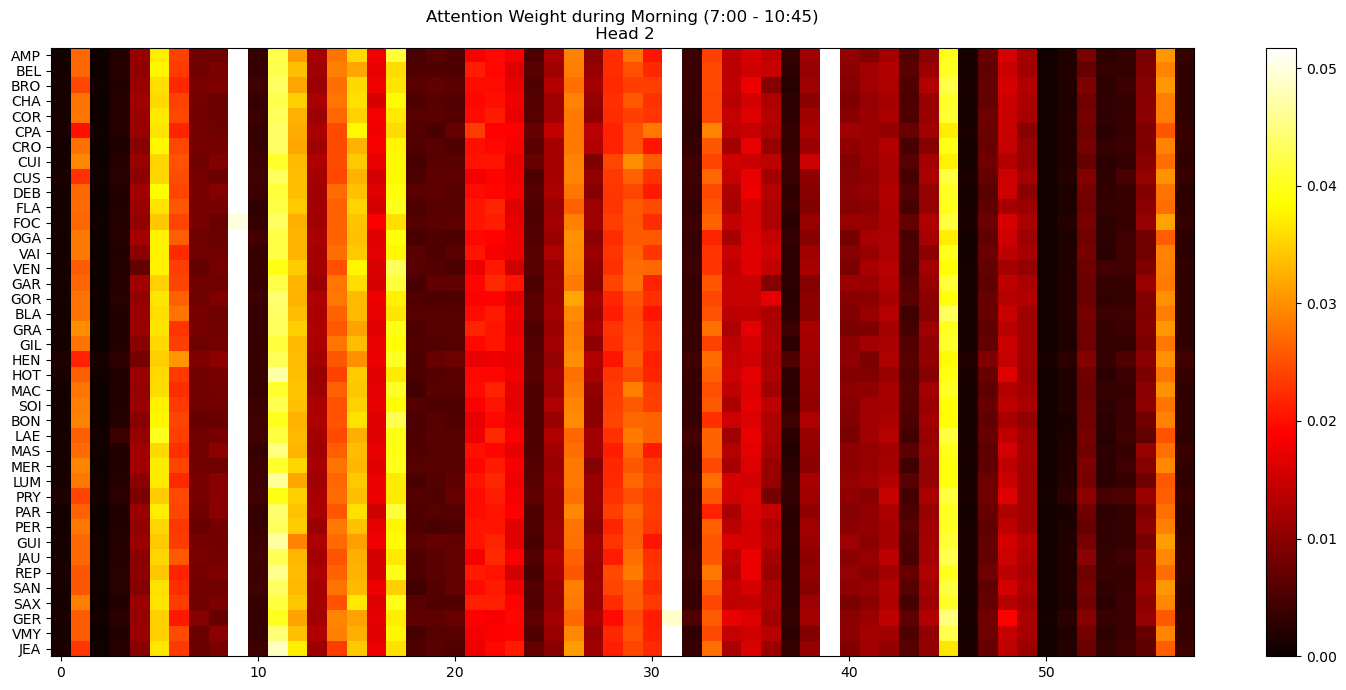

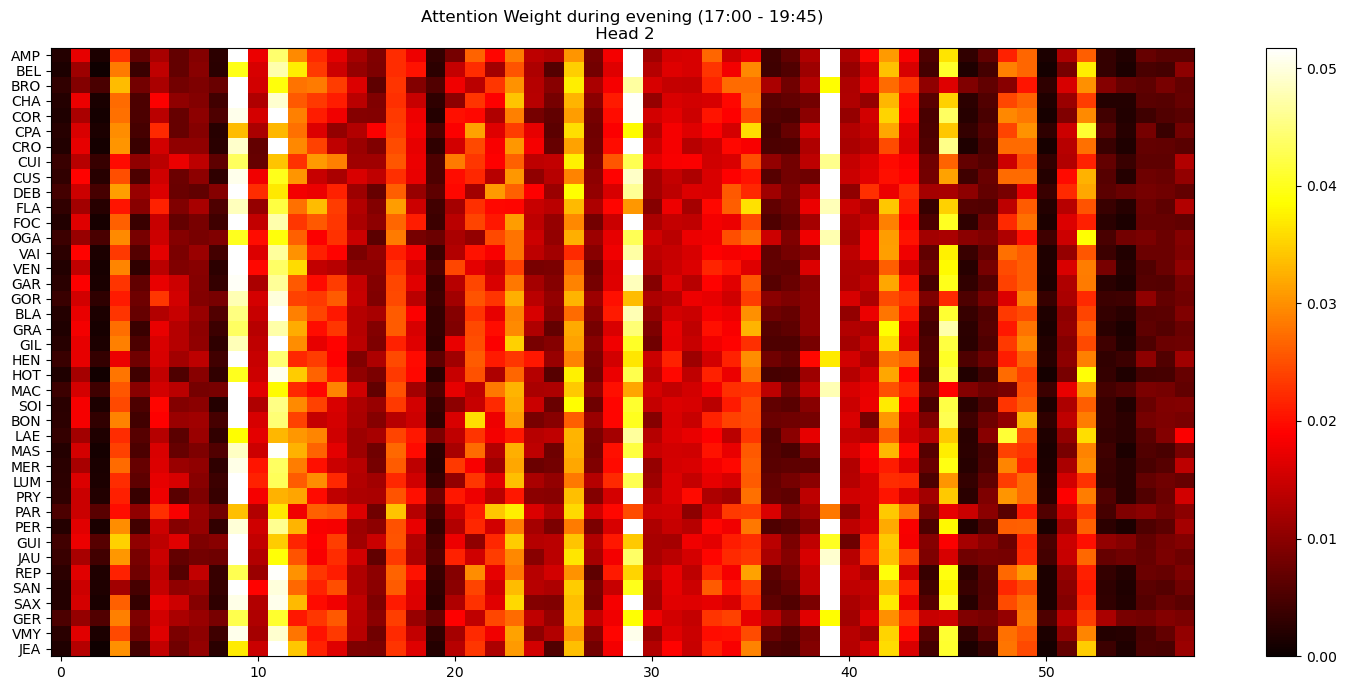

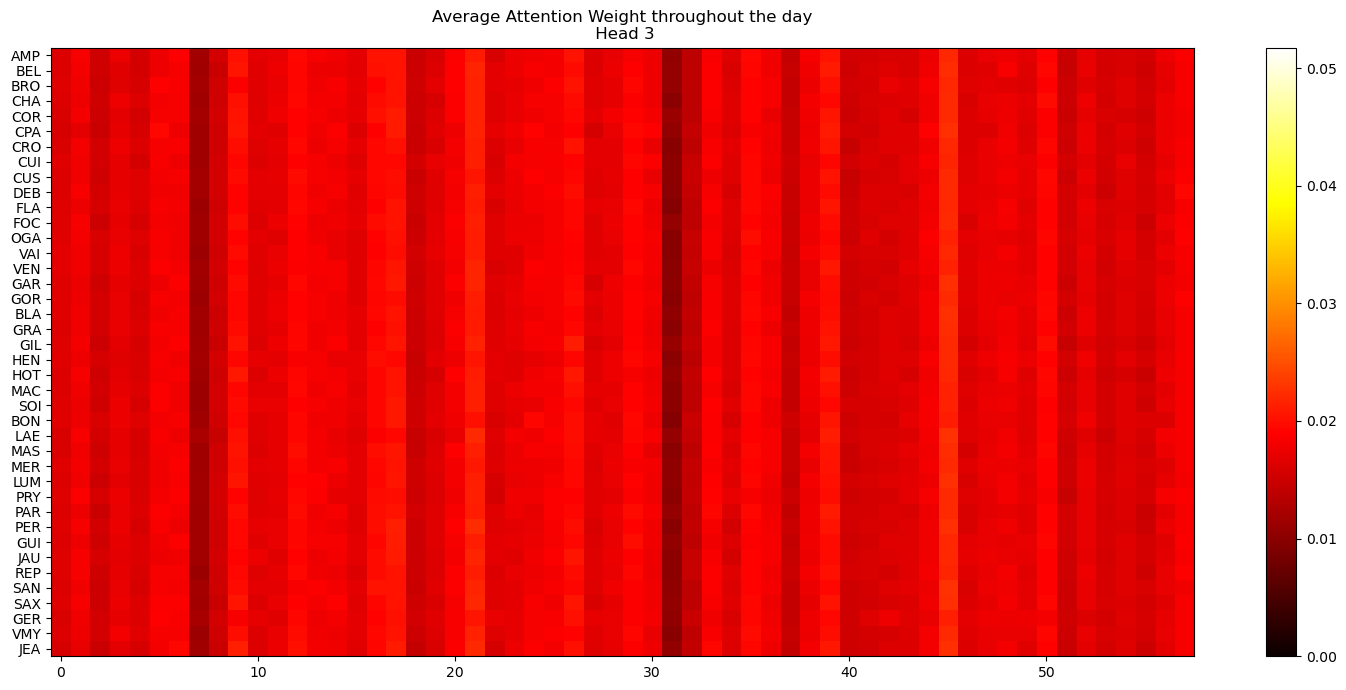

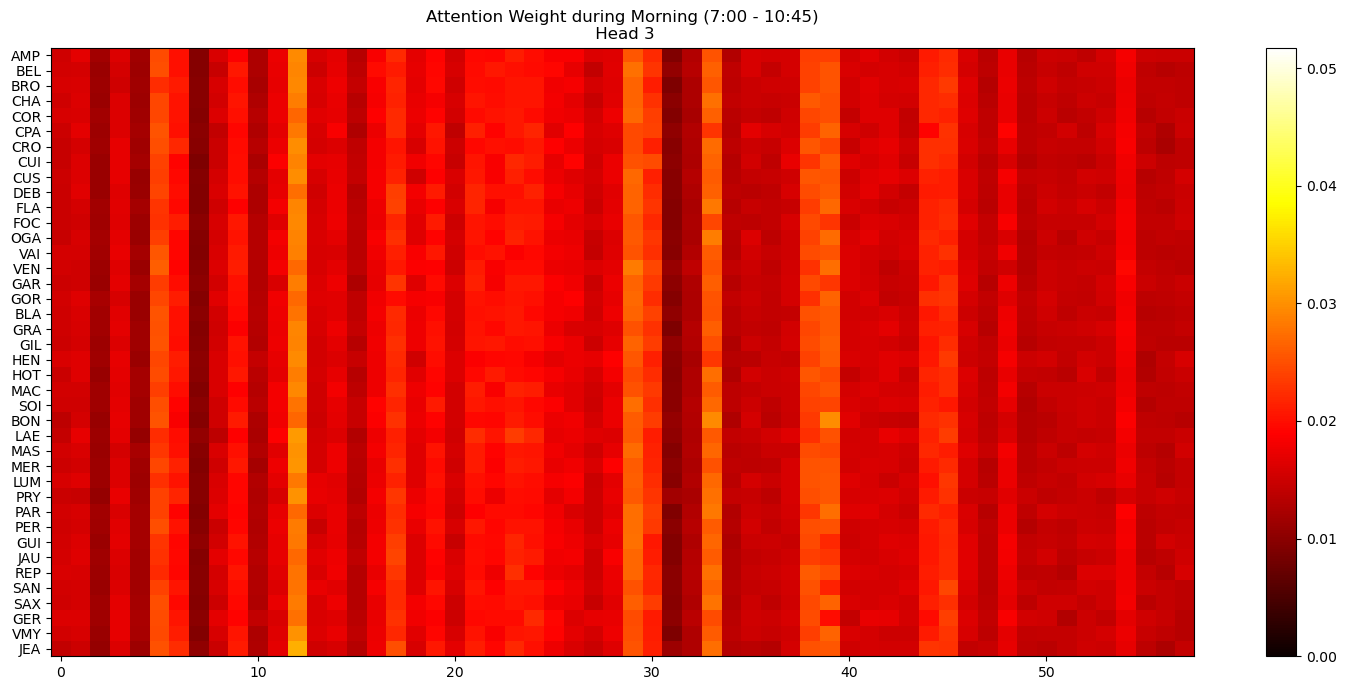

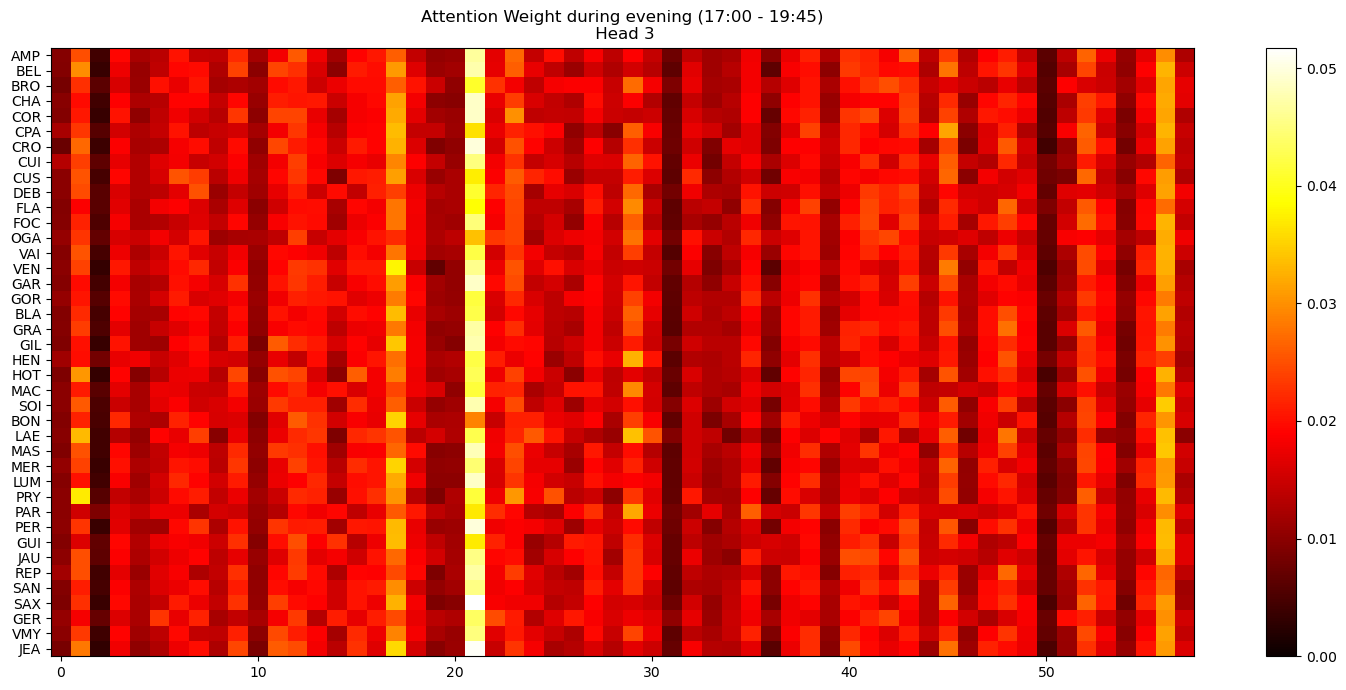

In [123]:
# ----- Find Indices related to specifics period of the days: 
hours = Xc1.max(1).indices
weekdays = Xc0.max(1).indices
# Find the indices of the hours between 7 and 10 on torch tensor
mask_morning =  ((hours >= 7) & (hours <= 10)) & (weekdays <= 4)
indices_morning = torch.where(mask_morning)[0]

mask_evening =  ((hours >= 17) & (hours <= 19)) & (weekdays <= 4)
indices_evening = torch.where(mask_evening)[0]
# -----

# head = 0


uniform_weight = 1/test_NetMob_attn_weights.size(-1)
vmin = 0
vmax = min(1,uniform_weight*3)


for head in range(test_NetMob_attn_weights.size(1)):
    
    # -- Average Attention Weight : 
    average_attn_weight = test_NetMob_attn_weights.mean(0)   # [heads, stations, Iris]
    plot_heatmap(average_attn_weight[head].detach().cpu().numpy(),ylabel =ds.spatial_unit,figsize = (15,7) ,title=f'Average Attention Weight throughout the day\n Head {head}',vmin=vmin,vmax=vmax)

    # -- Morning Average Attention Weight : 
    morning_attn_weight = torch.index_select(test_NetMob_attn_weights, 0, indices_morning).mean(0)
    plot_heatmap(morning_attn_weight[head].detach().cpu().numpy(), title=f'Attention Weight during Morning (7:00 - 10:45)\n Head {head}',ylabel =ds.spatial_unit,figsize = (15,7),vmin=vmin,vmax=vmax)

    # -- Evening Attention Weight : 
    evening_attn_weight = torch.index_select(test_NetMob_attn_weights, 0, indices_evening).mean(0)
    plot_heatmap(evening_attn_weight[head].detach().cpu().numpy(), title=f'Attention Weight during evening (17:00 - 19:45)\n Head {head}',ylabel =ds.spatial_unit,figsize = (15,7),vmin=vmin,vmax=vmax)

## plot Attention Weight:

In [ ]:
netmob_folder = '../../../../data/rrochas/prediction_validation/POIs'
tag = 'iris'

geojson_path = f"{netmob_folder}/gdf_{tag}.geojson"


print(f'Osmid associated to the tag {tag}')
# Load gdf :
gdf = gpd.read_file(geojson_path).drop(columns = ['type','sub_type'])
gdf.osmid = gdf.osmid.astype(int).astype(str)

# init : 
head = 0 
station = ['PAR']
station_name = station[0]

Osmid associated to the tag iris


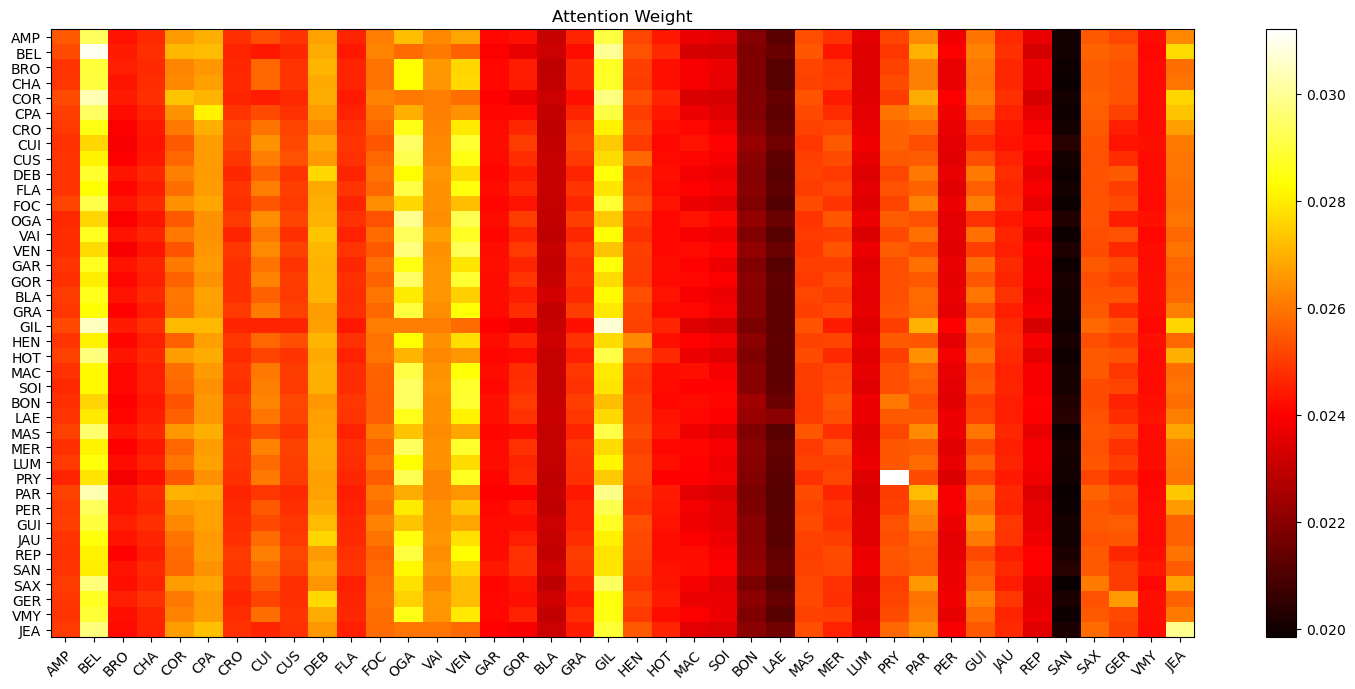

In [34]:
## Spatial Attention Weights on the last layer: 

plot_heatmap(test_spatial_attn_weight.reshape(-1,4,7,40,40).mean([0,1,2]).detach().cpu().numpy(), xlabel = ds.spatial_unit,ylabel =ds.spatial_unit , title='Attention Weight',figsize = (15,7))

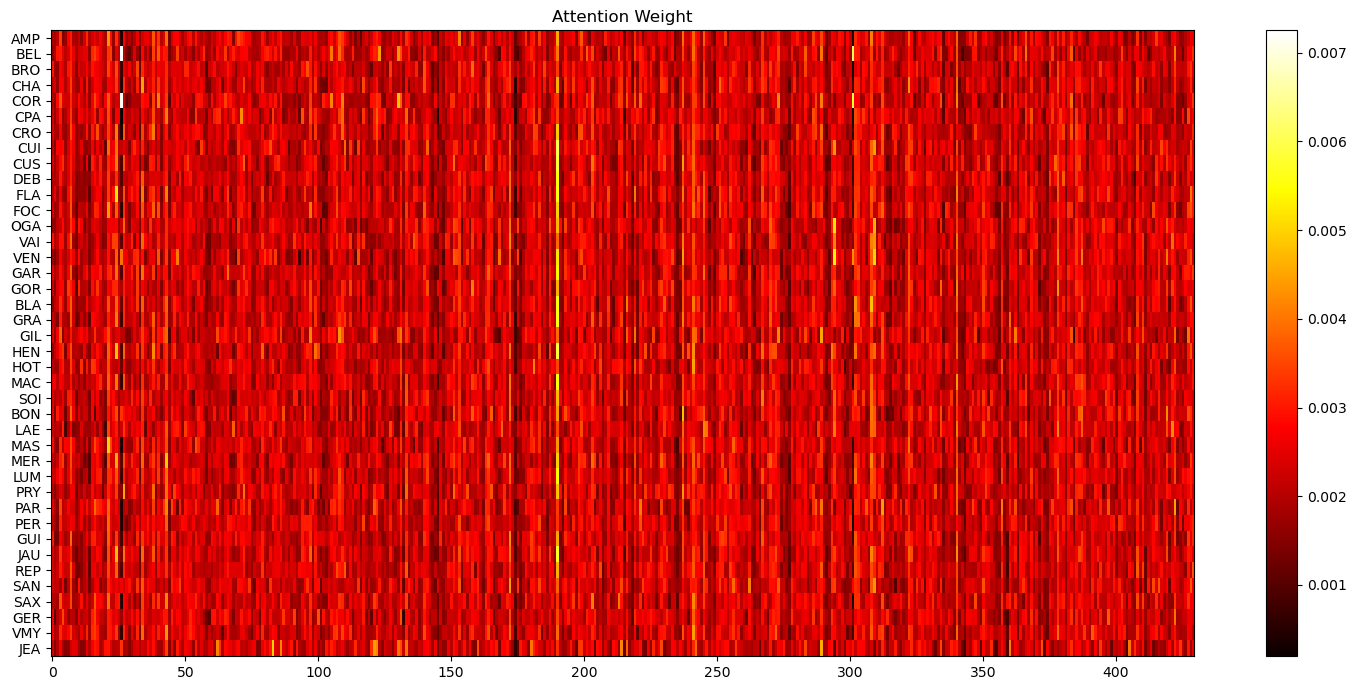

Visualisation of the attention weight for the station: PAR averaged on all time-slots  and head 0 out of 3


Traceback (most recent call last):
  File "/root/anaconda3/envs/pytorch-2.0.1/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/root/anaconda3/envs/pytorch-2.0.1/lib/python3.10/multiprocessing/connection.py", line 182, in close
    self._close()
  File "/root/anaconda3/envs/pytorch-2.0.1/lib/python3.10/multiprocessing/connection.py", line 366, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


In [36]:
# Average Attention Weight : 
average_attn_weight = test_NetMob_attn_weights.mean(0)   # [heads, stations, Iris]
plot_heatmap(average_attn_weight[0].detach().cpu().numpy(),ylabel =ds.spatial_unit,figsize = (15,7) ,title='Attention Weight')


# Visualisation : 
station_ind = list(ds.spatial_unit).index(station_name)
attn_weight_i = average_attn_weight[head,station_ind,:]
print(f'Visualisation of the attention weight for the station: {station_name} averaged on all time-slots  and head {head} out of {average_attn_weight.size(0)}')
gdf['attn_weight'] = attn_weight_i.detach().cpu().numpy()
gdf.explore('attn_weight',cmpa = 'hot')

## Attention Weight on Weekday and Evening Peak Hour: 

In [37]:
# tod contains float between 0 and 1, representing the time of day in % 
tod = Xc1[:,-1]

# Get tensors indices where tod > 7/24 and tod < 10/24
indices_tod = torch.where((tod > 17/24) & (tod < 19/24))[0]

# dow contains integers between 0 and 6, representing the day of the week (0 = Monday, 6 = Sunday)
dow = Xc1[:,-1].long()
# Get tensors indices where dow is a working day:
indices_dow = torch.where((dow >= 0) & (dow <= 4))[0]

evening_hours = list(set(indices_dow.detach().cpu().numpy()) & set(indices_tod.detach().cpu().numpy()))
print(f"Number of time-slots associated to evening hour within test-dataset: {len(evening_hours)}")

Number of time-slots associated to evening hour within test-dataset: 97


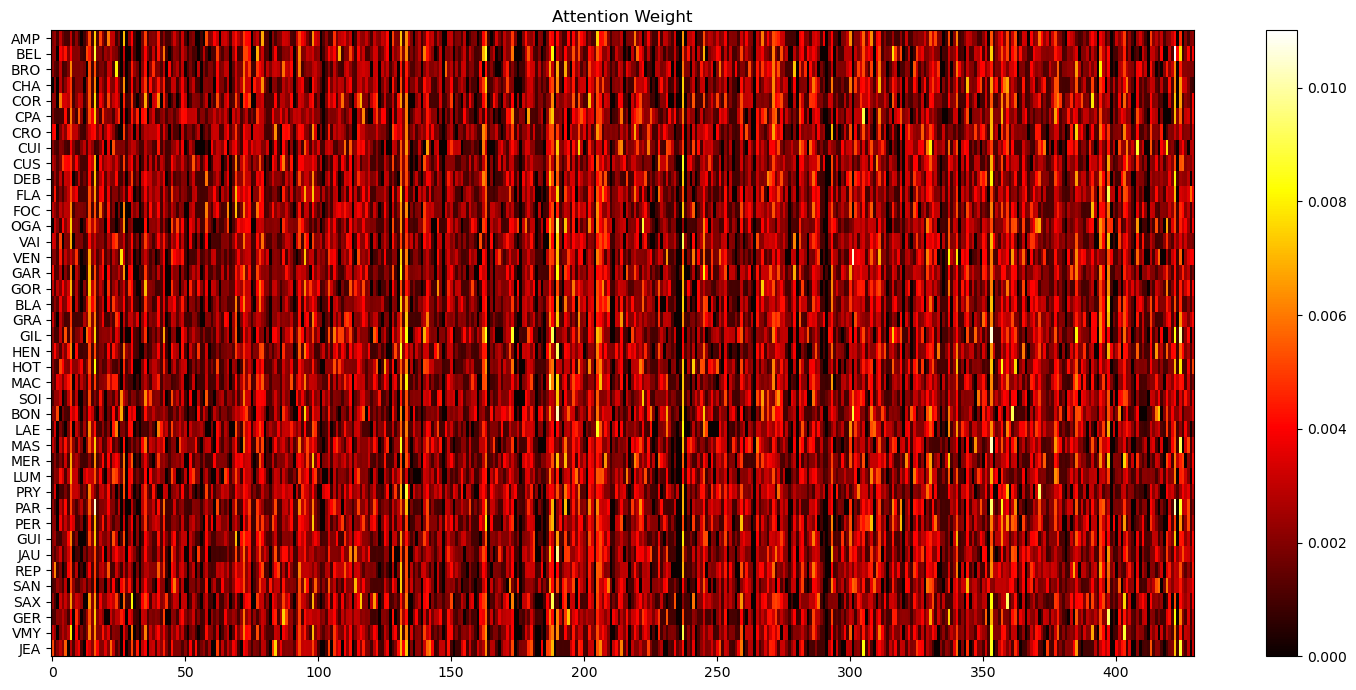

Visualisation of the attention weight for the station: PAR averaged on all time-slots  and head 0 out of 3


In [38]:
# Average Morning Attention Weight : 
evening_attn_weight = torch.index_select(test_NetMob_attn_weights, 0, torch.tensor(evening_hours).to(test_NetMob_attn_weights).long()).mean(0)

plot_heatmap(evening_attn_weight[head].detach().cpu().numpy(), title='Attention Weight',ylabel =ds.spatial_unit,figsize = (15,7))


# Visualisation : 
station_ind = list(ds.spatial_unit).index(station_name)
attn_weight_i = evening_attn_weight[0,station_ind,:]
print(f'Visualisation of the attention weight for the station: {station_name} averaged on all time-slots  and head {head} out of {evening_attn_weight.size(0)}')
gdf['attn_weight'] = attn_weight_i.detach().cpu().numpy()
gdf.explore('attn_weight',cmpa = 'hot')

## Attention Weight on Weekday and Morning Peak Hour: 

In [39]:
# tod contains float between 0 and 1, representing the time of day in % 
tod = Xc1[:,-1]

# Get tensors indices where tod > 7/24 and tod < 10/24
indices_tod = torch.where((tod > 7/24) & (tod < 9.5/24))[0]

# dow contains integers between 0 and 6, representing the day of the week (0 = Monday, 6 = Sunday)
dow = Xc1[:,-1].long()
# Get tensors indices where dow is a working day:
indices_dow = torch.where((dow >= 0) & (dow <= 4))[0]

morning_hours = list(set(indices_dow.detach().cpu().numpy()) & set(indices_tod.detach().cpu().numpy()))
print(f"Number of time-slots associated to morning hour within test-dataset: {len(morning_hours)}")

Number of time-slots associated to morning hour within test-dataset: 108


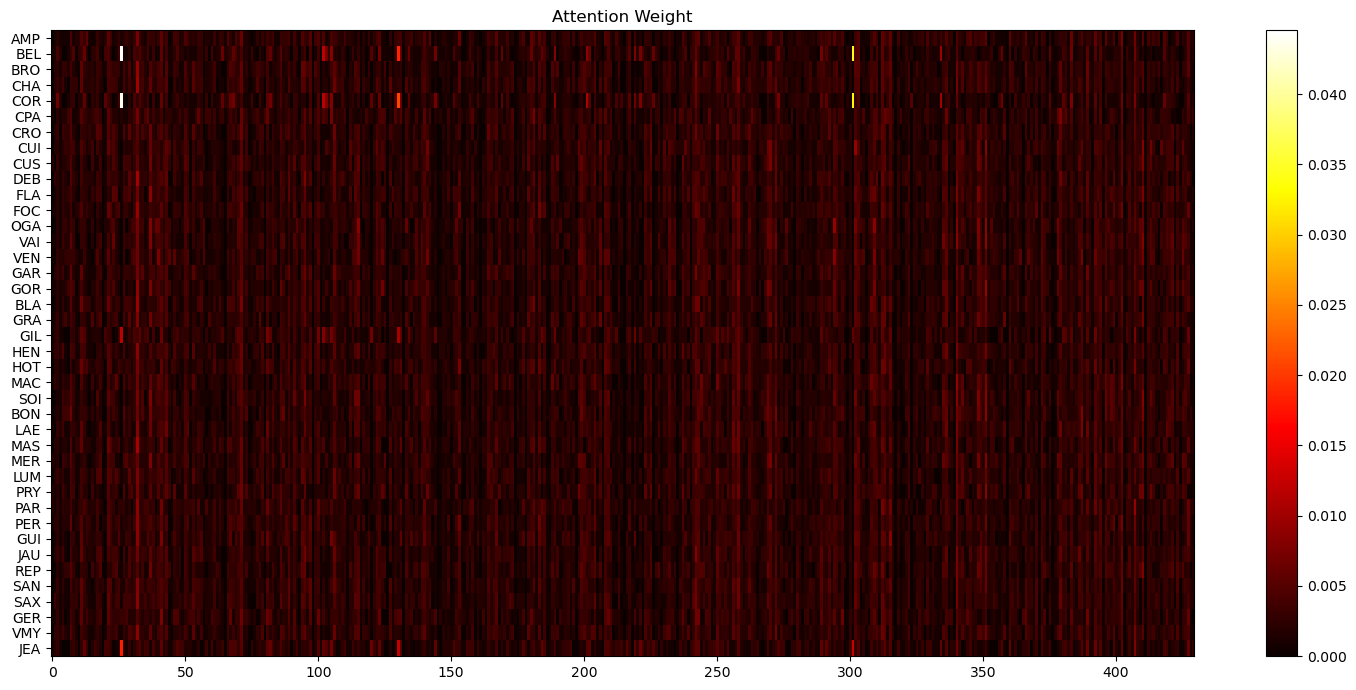

Visualisation of the attention weight for the station: PAR averaged on all time-slots  and head 0 out of 3


In [40]:
# Average Morning Attention Weight : 
morning_attn_weight = torch.index_select(test_NetMob_attn_weights, 0, torch.tensor(morning_hours).to(test_NetMob_attn_weights).long()).mean(0)

plot_heatmap(morning_attn_weight[head].detach().cpu().numpy(), title='Attention Weight',ylabel =ds.spatial_unit,figsize = (15,7))


# Visualisation : 
station_ind = list(ds.spatial_unit).index(station_name)
attn_weight_i = morning_attn_weight[0,station_ind,:]
print(f'Visualisation of the attention weight for the station: {station_name} averaged on all time-slots  and head {head} out of {morning_attn_weight.size(0)}')
gdf['attn_weight'] = attn_weight_i.detach().cpu().numpy()
gdf.explore('attn_weight',cmpa = 'hot')

##  Attention Weight at Monday 8:30am :

Lundi 8h30m


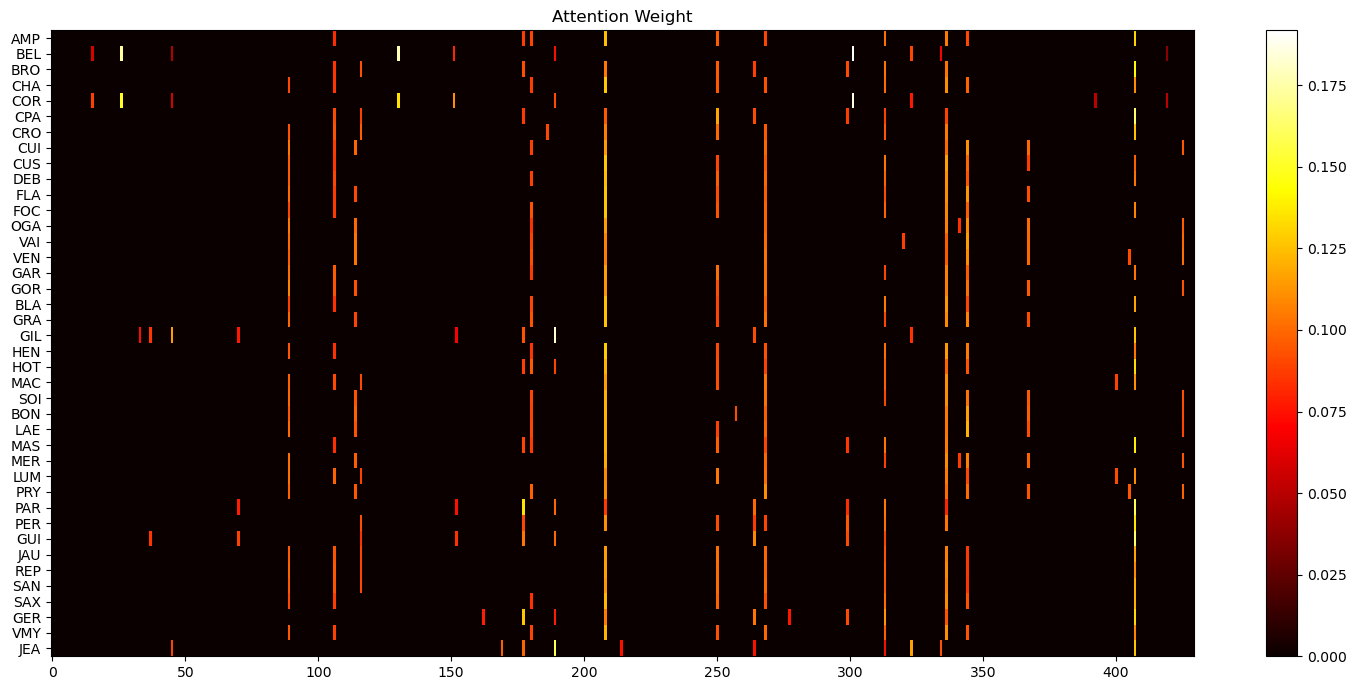

Visualisation of the attention weight for the station: PAR  at time slot: 310 and head 0 out of 3


In [42]:
timeslot = 310

dow = int(Xc0[timeslot,-1].item())
tod = Xc1[timeslot,-1]*24
h = int(tod)
days = ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche']
print(f"{days[dow]} {h}h{int((tod-h)*60)}m")

attn_weight = test_NetMob_attn_weights[timeslot]
plot_heatmap(attn_weight[0].detach().cpu().numpy(), title='Attention Weight',ylabel =ds.spatial_unit,figsize = (15,7))

# Visualisation : 
station_ind = list(ds.spatial_unit).index(station_name)
attn_weight_i = attn_weight[head,station_ind,:]
print(f'Visualisation of the attention weight for the station: {station_name}  at time slot: {timeslot} and head {head} out of {average_attn_weight.size(0)}')
gdf['attn_weight'] = attn_weight_i.detach().cpu().numpy()
gdf.explore('attn_weight',cmpa = 'hot')